# Tobac tracking of cloud systems based on IR brightness temperatures

Example for feature detection and segmentation based on merged IR brightness temperatures in 30 min timesteps: https://cmr.earthdata.nasa.gov/search/concepts/C1432254058-GES_DISC.html

I am checking here whether all features that are detected can be found in segmentation mask. This depends on the segmentation method chosen: If the segmentation threshold is chosen to be smaller or equal to one of the threshold used for the feature detection, not all features can be found in the segmentation mask. 

In [1]:
from pathlib import Path
import numpy as np 
import xarray as xr
import matplotlib.pyplot as plt
import tobac
import iris
import pandas as pd
%matplotlib inline

## Read in one month of  30 min IR brightness temperatures with 0.1 deg spatial resolution which is used here for the cloud feature detection 


In [2]:
# aggregated file for August 2016 
tbb_file = '/media/juli/Data/projects/data/satellite_data/ncep/ctt/2016/merg_201608.nc4'
tbb=iris.load_cube(tbb_file, 'brightness_temperature')

# 1. Compare feature IDs with numbers in segmentation mask when segmentation threshold is NOT used for feature detection

## Parameters

In [3]:
# temporal and spatial resolution (in seconds and meter)
dt= 1800
dxy = 14126.0

### Feature detection ###
parameters_features={}
parameters_features['position_threshold']='weighted_diff' # diff between specific value and threshold for weighting when finding the center location (instead of just mean lon/lat)
parameters_features['min_distance']=0 # minimum distance between features 
parameters_features['sigma_threshold']=0.5 # for slightly smoothing (gaussian filter)
parameters_features['n_erosion_threshold']=0 # pixel erosion (for more robust results)
parameters_features['threshold']=[230, 225, 220, 215, 210, 205, 200] #step-wise threshold for feature detection 
parameters_features['n_min_threshold']=250 # minimum nr of contiguous pixels for thresholds
parameters_features['target']= 'minimum'


### Segmentation ###
parameters_segmentation={}
parameters_segmentation['target'] = 'minimum'
parameters_segmentation['method']='watershed'
parameters_segmentation['threshold']=245  # threshold value until which the area is taken into account (detected feature is diluted with neighboring cells below this threshold)

# directory to save output in 
savedir = Path('/media/juli/Data/projects/mcs_tracking/CTT/analysis/')

## Feature detection and Segmentation


In [ ]:
features=tobac.feature_detection_multithreshold(tbb,dxy,**parameters_features)
features.to_hdf(savedir / 'Features_201608.h5', 'table')


Mask, Features_cells = tobac.segmentation_2D(features, tbb,
                                                             dxy, **parameters_segmentation)

iris.save([Mask], savedir/ 'Mask_Segmentation_201608.nc',zlib=True,complevel=4)                
Features_cells.to_hdf(savedir /'Features_cells_201608.h5','table')

In [4]:
# read in file for detected features 
savedir = Path('/media/juli/Data/projects/data/satellite_data/ncep/ctt/Save/tbbtracking/')
features = pd.read_hdf(savedir/ 'Features_cells_201608.h5', 'table')
features.head()

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,latitude,longitude,ncells
0,0,14,27.917526,121.580201,221,230,1,2016-08-01,2016-08-01 00:00:00,17.741753,72.208021,584
1,0,43,68.603300,228.347309,117,230,2,2016-08-01,2016-08-01 00:00:00,21.810330,82.884729,358
2,0,61,95.435984,108.477185,110,230,3,2016-08-01,2016-08-01 00:00:00,24.493599,70.897716,295
3,0,62,93.543377,303.175113,117,230,4,2016-08-01,2016-08-01 00:00:00,24.304338,90.367509,191
4,0,34,52.440272,97.101160,119,225,5,2016-08-01,2016-08-01 00:00:00,20.194027,69.760116,933


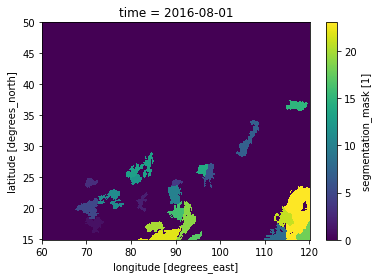

In [5]:
# read in file for mask 
mask = xr.open_dataset(savedir/ 'Mask_Segmentation_201608.nc')
segmask= mask.segmentation_mask

# plot first timestep of segmentation mask
segmask.isel(time=0).plot(x="lon", y="lat")

## Comparison

In [6]:
# check how many features are not in mask 

array = xr.DataArray(features.feature.values, dims="x")
count= array.isin(segmask).sum()
print(count.values/ features.feature.values.shape[0] * 100)

99.52267303102626


**-> almost, but not exactly 100 % of the feature IDs exist in segmentation mask!**

# 2. Compare feature IDs with numbers in segmentation mask when segmentation threshold is also used for feature detection

## Parameters 

In [7]:
# temporal and spatial resolution (in seconds and meter)
dt= 1800
dxy = 14126.0

### Feature detection ###
parameters_features={}
parameters_features['position_threshold']='weighted_diff' # diff between specific value and threshold for weighting when finding the center location (instead of just mean lon/lat)
parameters_features['min_distance']=0 # minimum distance between features 
parameters_features['sigma_threshold']=0.5 # for slightly smoothing (gaussian filter)
parameters_features['n_erosion_threshold']=0 # pixel erosion (for more robust results)
parameters_features['threshold']=[221, 218, 216, 214, 212, 210, 205, 200,195, 190] #step-wise threshold for feature detection 
parameters_features['n_min_threshold']=250 # minimum nr of contiguous pixels for thresholds
parameters_features['target']= 'minimum'

### Segmentation ###
parameters_segmentation={}
parameters_segmentation['target'] = 'minimum'
parameters_segmentation['method']='watershed'
parameters_segmentation['threshold']=221  # threshold value until which the area is taken into account (detected feature is diluted with neighboring cells below this threshold)

# directory to save output in 
savedir = Path('/media/juli/Data/projects/mcs_tracking/CTT/analysis/')

## Feature detection and segmentation 

In [ ]:
features=tobac.feature_detection_multithreshold(tbb,dxy,**parameters_features)
features.to_hdf(savedir / 'Features_201608.h5', 'table')


Mask, Features_cells = tobac.segmentation_2D(features, tbb,
                                                             dxy, **parameters_segmentation)

iris.save([Mask], savedir/ 'Mask_Segmentation_201608.nc',zlib=True,complevel=4)                
Features_cells.to_hdf(savedir /'Features_cells_201608.h5','table')

In [8]:
# read in file for detected features 
features = pd.read_hdf(savedir/ 'Features_201608.h5', 'table')
features.head()

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,latitude,longitude
0,0,9,10.141983,594.484056,260,221,1,2016-08-01,2016-08-01 00:00:00,15.964198,119.498405
1,0,26,41.563251,326.280868,262,221,2,2016-08-01,2016-08-01 00:00:00,19.106325,92.678088
2,0,57,105.120764,213.045495,293,221,3,2016-08-01,2016-08-01 00:00:00,25.462077,81.354548
3,0,96,69.121445,299.326966,289,218,4,2016-08-01,2016-08-01 00:00:00,21.862145,89.982696
4,0,118,42.752661,306.182018,253,216,5,2016-08-01,2016-08-01 00:00:00,19.225266,90.668203


## Comparison

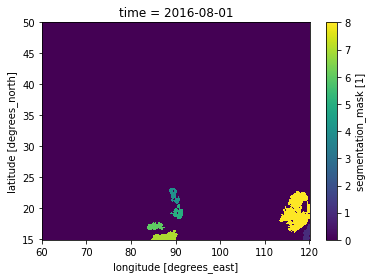

In [9]:
# read in file for mask 
mask = xr.open_dataset(Path('/media/juli/Data/projects/data/satellite_data/ncep/ctt/Save/tbbtracking_revised/Mask_Segmentation_20160808.nc'))
segmask= mask.segmentation_mask

# plot first timestep of segmentation mask
segmask.isel(time=0).plot(x="lon", y="lat")

In [37]:
# check how many features are not in mask 

array = xr.DataArray(features.feature.values, dims="x")
count= array.isin(segmask).sum()
print(count.values/ features.feature.values.shape[0] * 100)

93.89055472263868


**-> only 93 % of the feature IDs can be found in the segmentation mask!**